#**CHAPTER 3. FX CARRY TRADES**
---

##0.REFERENCE

https://chatgpt.com/share/6988a5fa-1f98-8012-9e47-a493747853a8

##1.CONTEXT

**Introduction**

This notebook is a mechanism laboratory for one of the most persistent and most misunderstood phenomena in global macro trading: FX carry. The objective is not to forecast exchange rates, discover a predictive signal, or optimize a strategy. The objective is to make the economic structure explicit, tradable, and fragile in a controlled environment. If the notebook does its job, you will come away with a clearer mental model of why carry exists, what the “surface” really represents, how regime dependence changes the mapping from surface to realized PnL, and why execution constraints are not an implementation detail but part of the mechanism.

FX carry is easiest to describe and hardest to internalize. In calm environments, interest-rate differentials translate into forward points that appear to offer a steady premium: one currency yields more than another, so holding the high-yielding currency seems to earn a persistent edge. The reason this pattern survives decades of scrutiny is that it is not a statistical anomaly. It is a compensation scheme embedded in the plumbing of money markets. The forward curve encodes the cost of funding and the reward for providing it. That reward is real, but it is not free. It is paid for by exposure to adverse states of the world where funding conditions tighten and safe-haven dynamics dominate. The premium is a risk premium, not a free lunch.

A mechanism-first approach forces this logic into the foreground. Instead of starting from price histories and asking what predicts what, we start from the economic primitives that must hold for an FX forward market to exist: short rates by currency, a funding base currency, and a state variable representing risk sentiment or funding stress. From these primitives, the notebook constructs a tradable surface: a carry matrix over currencies and tenors. This is not an aesthetic choice. A surface is the right abstraction because the market itself is organized as a family of related instruments whose prices co-move by construction. In FX, the forward points at different maturities are not independent “features.” They are coupled objects arising from rate differentials and tenor scaling, and traders interact with that surface as a coherent structure.

The notebook therefore builds three linked layers. First, a synthetic market simulator generates a two-regime world: a calm regime in which carry is earned slowly and volatility is moderate, and a risk-off regime in which volatility rises, funding premia compress, and the high-yield basket tends to suffer drawdowns that may cluster. Second, the simulator produces the tradable surface: a currency-by-tenor carry matrix derived from synthetic short rates. Third, an agent trades a constrained set of actions against a portfolio and execution environment that applies costs, impact, leverage limits, and a drawdown survival constraint. The backtest is closed loop: the agent’s discrete actions produce trades, trades incur costs, costs and market moves generate PnL, and the evolving equity and constraints govern what can be done next.

The agentic architecture is intentionally restrictive. The action space is discrete and auditable: flat, long the high-yield basket, short the high-yield basket, or a risk-off neutral mode that reduces exposure when stress is present. This constraint is not cosmetic. It prevents the notebook from smuggling mechanism understanding into continuous sizing choices that are difficult to interpret. When the agent chooses “long carry,” it is committing to the core economic exposure. When it chooses “short carry,” it is expressing a funding-stress hedge. When it goes neutral, it is emphasizing survival over harvesting. This produces decisions that are legible as economic statements rather than numerical optimizations.

Two policy layers are implemented. The baseline policy is deterministic and interpretable, intended as a transparent reference. It maps regime and risk sentiment into discrete actions with short rationales. The optional LLM policy is a second decision layer that is strictly constrained: it may only select from the predefined action list and provide short rationales. It cannot modify parameters, change code, or invent new actions. In this notebook, the LLM is used as a decision component, not as a model builder. The purpose is to explore how a language model behaves when embedded in a controlled mechanism laboratory with explicit constraints, and to compare its choices to a baseline rule policy under the same environment.

Execution realism is treated as part of the mechanism. The notebook does not assume frictionless trading. Each position change generates turnover, and turnover generates costs. Costs have two components: a proportional transaction-cost term and an impact proxy that is higher in risk-off states. This reflects a simple but essential reality: the same trade that is cheap in calm markets becomes expensive when everyone is trying to do it at once. The environment also enforces leverage and position limits so the agent cannot hide behind unbounded scaling, and it includes a drawdown stop as an explicit survivability constraint. This matters for interpretation: a risk premium whose distribution is dominated by rare, clustered losses is not meaningfully understood unless path dependence and survival rules are explicit.

The notebook’s outputs are diagnostics designed to connect mechanism to observed behavior. The equity curve is not a score; it is a visual narrative of how the mechanism pays and how it breaks. The regime plot provides the conditional context needed to interpret PnL clustering. The cost accumulation curve is the accounting of execution reality, showing when turnover and impact dominate. Action counts reveal whether the agent is actually behaving differently across regimes or simply repeating one exposure. Summary metrics provide compact descriptors of distributional outcomes, and the interpretive mechanism table forces the notebook to state, in words, what is structurally going on: which object is being traded, what evidence you should see, what fragility looks like, and why execution constraints change the outcome.

Mechanism-first thinking is deliberately anti-hype. It is a discipline of asking: what must be true for this premium to exist, and what adverse states must be paid for to harvest it. For FX carry, the core idea is that forward carry is a conditional object. In calm states, the forward curve can look like a stable slope that invites harvesting. In stress states, the same curve is often accompanied by higher volatility, compressed differentials, and higher execution costs. The risk premium is paid precisely because the mapping from “carry surface” to “realized return” is regime dependent and path dependent. A mechanism-first notebook should make that dependence visible, not hide it behind averaged statistics.

The intended use of this notebook is experimental. You are expected to vary regime persistence, volatility levels, jump intensity, the dispersion of rate differentials across currencies, and the severity of liquidity stress. The goal is to observe how surfaces emerge, how fragility manifests, and how execution dominates the realized distribution. If you treat the notebook as a laboratory, not a strategy, you can use it to develop professional intuition that transfers beyond FX: any carry-like structure in macro finance is a premium paid for being structurally short convexity in adverse states, and any agent interacting with that structure must treat constraints and execution as part of the economic object being traded.



##2.LIBRARIES AND ENVIRONMENT

In [1]:
# CELL 2 (CODE) — REWRITE COMPLETE (config + utilities + logging)
# Chapter 3: FX Forward Carry (Mechanism-First Agentic Market Laboratory)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

# -----------------------
# Run config (reproducible)
# -----------------------
run_config: Dict[str, Any] = {
    "chapter_id": 3,
    "chapter_name": "FX Carry — Forward Carry System",
    "seed": 7,

    # Horizon / discretization
    "T": 800,
    "dt": 1 / 252,

    # Synthetic currency universe (vs USD)
    "n_ccy": 6,
    "ccy_names": ["AUD", "NZD", "CAD", "NOK", "MXN", "ZAR"],

    # Regime process (two-state Markov)
    # 0 = calm, 1 = risk_off
    "regimes": {
        "names": ["calm", "risk_off"],
        # More frequent risk_off + stronger clustering than the earlier version
        "P": np.array([
            [0.970, 0.030],
            [0.200, 0.800]
        ])
    },

    # Market mechanisms: carry in calm, unwind in stress
    "market_params": {
        "mechanism": (
            "interest differentials create forward carry in calm; "
            "risk_off compresses spreads, raises vol, and produces USD safe-haven rallies with jump risk"
        ),

        # Rates (annualized)
        "usd_rate": 0.030,
        "rate_mean_spread": 0.025,
        "rate_spread_disp": 0.010,
        "rate_revert_kappa": 2.0,

        # Spot dynamics (annualized)
        "calm_vol": 0.08,
        "stress_vol": 0.35,
        "calm_drift": 0.00,
        "risk_off_drift": -0.20,        # stronger stress drift (USD up / HY down)

        # Tail events (carry unwind) in risk_off
        "jump_prob_risk_off": 0.10,
        "jump_size_mean": -0.05,
        "jump_size_std": 0.03
    },

    # Tradable surface definition
    "surface_params": {
        "tenors_days": [30, 90, 180],    # forward tenors (days)
        "surface_type": "carry_matrix",  # (currency × tenor)
        "carry_surface_note": "carry ~ (r_ccy - r_usd) * tenor_years"
    },

    # Execution realism (bps-level; regime-dependent impact)
    "execution_params": {
        "cost_bps": 1.5,                 # proportional costs (bps on turnover)
        "impact_bps_calm": 8.0,          # impact bps per unit turnover (calm)
        "impact_bps_risk_off": 35.0,     # impact bps per unit turnover (risk_off)
        "impact_exponent": 1.15          # mild convexity in turnover
    },

    # Risk constraints / controls
    "risk_params": {
        "max_leverage": 2.0,             # gross exposure / equity (scalar proxy)
        "pos_limit": 1.0,                # |position| bound
        "max_dd_stop": 0.25              # stop trading if drawdown exceeds threshold
    },

    # Policy layer (baseline + optional LLM)
    "policy_params": {
        "enable_llm": True,              # per your instruction: LLM ON
        "llm_model": "gpt-4o-mini",
        "llm_temperature": 0.0,
        "fallback_to_baseline_on_error": True
    }
}

# -----------------------
# Utilities (stable + explicit)
# -----------------------
def stable_soft_clip(x: float, lo: float, hi: float) -> float:
    return max(lo, min(hi, x))

def compute_drawdown(equity: np.ndarray) -> np.ndarray:
    peak = np.maximum.accumulate(equity)
    return 1.0 - equity / np.maximum(peak, 1e-12)

# -----------------------
# Step-level audit log schema
# -----------------------
@dataclass
class StepLog:
    t: int
    regime: str
    risk_s: float
    usd_rate: float
    ccy_rates_mean: float
    carry_30d_mean: float
    spot_ret: float
    action: str
    rationale: str
    position: float
    target_position: float
    trade_size: float
    leverage: float
    cost: float
    pnl: float
    equity: float

print("Loaded run_config:")
print("  chapter:", run_config["chapter_id"], "-", run_config["chapter_name"])
print("  T:", run_config["T"], "dt:", run_config["dt"], "n_ccy:", run_config["n_ccy"])
print("  regimes:", run_config["regimes"]["names"])
print("  P:\n", run_config["regimes"]["P"])
print("  execution (bps):", {k: run_config["execution_params"][k] for k in run_config["execution_params"]})
print("  LLM enabled:", run_config["policy_params"]["enable_llm"], "| model:", run_config["policy_params"]["llm_model"])


Loaded run_config:
  chapter: 3 - FX Carry — Forward Carry System
  T: 800 dt: 0.003968253968253968 n_ccy: 6
  regimes: ['calm', 'risk_off']
  P:
 [[0.97 0.03]
 [0.2  0.8 ]]
  execution (bps): {'cost_bps': 1.5, 'impact_bps_calm': 8.0, 'impact_bps_risk_off': 35.0, 'impact_exponent': 1.15}
  LLM enabled: True | model: gpt-4o-mini


##3.REGIME PROCESS AND STATE EVOLUTION

###3.1.OVERVIEW

**Cell 3**

Cell 3 establishes the state dynamics that make FX carry meaningful as an economic object rather than a statistical pattern. Its purpose is to generate a synthetic world in which the key drivers of carry exist and can change regime. This includes a two-state regime process, a risk sentiment variable, and a set of short rates for USD and a basket of synthetic currencies. The critical idea is that the carry surface does not appear by magic; it arises from relative funding conditions. By simulating rates explicitly, the notebook forces the forward carry to be anchored in an interpretable mechanism rather than treated as an unexplained input.

The regime process is the primary structural driver. In calm states, the system is designed to look stable: risk sentiment mean reverts with moderate noise and the rates evolve gently. In risk-off states, the same state variables behave differently, with higher noise and funding stress characteristics. This is essential for carry because the premium is not paid in a stationary environment. It is paid in a world where adverse states exist, cluster, and change both expected returns and execution conditions. The regime process therefore makes conditionality explicit: the same exposure will have different implications depending on the state.

Risk sentiment plays a complementary role as a continuous proxy for stress within regimes. Even within calm periods, elevated risk sentiment can serve as a warning that execution or volatility conditions are deteriorating. This variable is not intended as a predictive signal; it is intended as a mechanism knob that influences volatility and policy behavior in a way you can audit. By keeping risk sentiment separate from the regime indicator, the notebook creates an interpretable separation between discrete state shifts and continuous stress intensification.

The short-rate block creates the economic foundation for the carry surface. Each currency has a structural spread relative to USD, plus mean reversion and noise. In stress states, spreads compress, reflecting a funding squeeze: the premium that looked attractive in calm becomes less attractive precisely when risks rise. This coupling is a central carry intuition. If carry were constant through stress, it would be closer to an arbitrage. The notebook therefore encodes a structural relationship that preserves the economic narrative: calm earns small premia, stress both removes the premium and increases the probability of adverse price moves.

Cell 3’s learning objective is to make you comfortable reading state variables as economic levers. You should be able to point to a regime transition and say what it means for funding, volatility, and expected outcomes. You should also be able to see how the carry surface you will build later must inherit its shape from this state. In mechanism-first work, this cell is the “physics engine” of the market: it defines what is possible downstream and what fragility is being priced.


###3.2.CODE AND IMPLEMENTATION

In [2]:

def simulate_regimes(P: np.ndarray, T: int, seed: int) -> np.ndarray:
    """
    Two-state Markov chain:
      0 = calm
      1 = risk_off
    """
    rng = np.random.default_rng(seed)
    reg = np.zeros(T, dtype=int)
    for t in range(1, T):
        reg[t] = rng.choice([0, 1], p=P[reg[t-1]])
    return reg

def simulate_state(
    T: int,
    dt: float,
    n_ccy: int,
    seed: int,
    params: Dict[str, Any],
    P: np.ndarray
) -> Dict[str, Any]:
    """
    State variables (synthetic, explicit):
      - regimes[t]        : Markov regime (calm vs risk_off)
      - risk_s[t]         : risk sentiment (mean reverting, regime-dependent noise)
      - usd_rate[t]       : USD short rate (slow drift, clipped)
      - ccy_rates[t, i]   : currency short rates (mean reverting to USD + spread, stress compression)
      - base_spreads[i]   : structural spread advantage (heterogeneous across currencies)

    Design goal:
      Ensure visible stress segments so the carry mechanism is observed every run.
    """
    rng = np.random.default_rng(seed)

    # --- Regime path
    regimes = simulate_regimes(P, T, seed=seed + 11)

    # Force a few stress windows so the mechanism always appears (pedagogical invariant)
    rng_inject = np.random.default_rng(seed + 999)
    n_windows = 3
    win_len = 18
    if T > (win_len + 60):
        starts = rng_inject.integers(low=50, high=T - win_len - 1, size=n_windows)
        for s in starts:
            regimes[s:s + win_len] = 1

    # --- Risk sentiment: mean-reverting latent risk factor
    risk_s = np.zeros(T)
    kappa = 5.0
    sigma_calm = 0.8
    sigma_stress = 2.0

    # --- Rates: USD + heterogeneous spreads; stress compresses spreads (funding squeeze)
    usd_rate = np.full(T, params["usd_rate"])
    base_spreads = params["rate_mean_spread"] + params["rate_spread_disp"] * rng.normal(size=n_ccy)

    ccy_rates = np.zeros((T, n_ccy))
    ccy_rates[0] = usd_rate[0] + base_spreads + 0.002 * rng.normal(size=n_ccy)

    kappa_r = params["rate_revert_kappa"]

    for t in range(1, T):
        is_stress = (regimes[t] == 1)

        # risk sentiment evolves with higher noise in stress
        sig = sigma_stress if is_stress else sigma_calm
        risk_s[t] = risk_s[t-1] + (-kappa * risk_s[t-1] * dt + sig * np.sqrt(dt) * rng.normal())

        # modest USD rate drift
        usd_rate[t] = stable_soft_clip(usd_rate[t-1] + 0.0005 * np.sqrt(dt) * rng.normal(), 0.0, 0.10)

        # stress compresses spreads (funding squeeze) -> reduces carry just when risk rises
        stress_spread_compression = -0.020 if is_stress else 0.0
        theta = usd_rate[t] + base_spreads + stress_spread_compression

        ccy_rates[t] = (
            ccy_rates[t-1]
            + kappa_r * (theta - ccy_rates[t-1]) * dt
            + 0.004 * np.sqrt(dt) * rng.normal(size=n_ccy)
        )
        ccy_rates[t] = np.clip(ccy_rates[t], 0.0, 0.25)

    return {
        "regimes": regimes,
        "risk_s": risk_s,
        "usd_rate": usd_rate,
        "ccy_rates": ccy_rates,
        "base_spreads": base_spreads
    }

# Run state simulation
state = simulate_state(
    T=run_config["T"],
    dt=run_config["dt"],
    n_ccy=run_config["n_ccy"],
    seed=run_config["seed"],
    params=run_config["market_params"],
    P=run_config["regimes"]["P"]
)

print("State simulated.")
print("Regime counts:", dict(zip(run_config["regimes"]["names"], np.bincount(state["regimes"], minlength=2))))
print("USD rate range:", float(state["usd_rate"].min()), "to", float(state["usd_rate"].max()))
print("Mean ccy rate range:", float(state["ccy_rates"].mean(axis=1).min()), "to", float(state["ccy_rates"].mean(axis=1).max()))


State simulated.
Regime counts: {'calm': np.int64(626), 'risk_off': np.int64(174)}
USD rate range: 0.027367570421076206 to 0.03
Mean ccy rate range: 0.043280020351519934 to 0.05152634992367244


##4.MARKET SIMULATOR

###4.1.OVERVIEW

**Cell 4**

Cell 4 constructs the tradable objects the agent will interact with: the spot return process and the carry surface. Its purpose is to bridge state variables into market observables in a way that preserves economic interpretability. The notebook does not treat “returns” as an opaque time series; it generates returns conditionally on regimes and stress, including the possibility of clustered losses. This is the mechanism-level representation of carry unwind: not a vague risk term, but a specific state-dependent behavior.

The spot return generator is regime dependent. In calm conditions, volatility is moderate and drift is close to neutral, meaning the position’s performance will primarily reflect carry rather than directional spot trends. In risk-off conditions, volatility rises and the drift becomes adverse for the high-yield basket, reflecting the stylized safe-haven behavior of USD against funding-sensitive currencies. Importantly, tail behavior is introduced via jump risk in stress states. This is a direct mechanism encoding of what practitioners call “carry crashes”: rare but significant moves that dominate the distribution. Without this, the laboratory would incorrectly suggest that carry is just a stable income stream.

The tradable surface is the carry matrix, built from rate differentials across currencies and tenors. The surface matters because it is the coherent object that describes forward compensation across maturities. Constructing it explicitly teaches a key intuition: carry is not a scalar; it is a structured function of tenor and funding differentials. Even in the simplified laboratory, the tenor scaling forces a consistent shape: longer tenors typically imply larger forward points because the rate differential is accrued over more time. This is not an optimization result; it is a structural property.

In addition to building the surface, the notebook extracts a portfolio-relevant proxy, such as the mean 30-day carry across currencies. This compresses a structured object into a scalar that the agent can trade with a discrete action set. The compression is intentional: it keeps the agent’s exposure interpretable while preserving a direct link back to the surface. You can still inspect the surface to understand why the proxy moved.

Cell 4’s learning objective is to teach surface thinking. You should interpret carry not as “a feature,” but as a tradable surface that evolves with state variables. You should also internalize that the distribution of realized returns is shaped by regime dependence and tail events. In mechanism laboratories, it is better to model a simplified surface faithfully than to model a complex return series without interpretability. This cell sets up exactly that trade: explicit structure over opaque realism.


###4.2.CODE AND IMPLEMENTATION

In [3]:
def build_carry_surface(usd_rate_t: float, ccy_rates_t: np.ndarray, tenors_days: List[int]) -> np.ndarray:
    """
    Carry surface: forward carry approximation per tenor.
    Forward carry ~ (r_ccy - r_usd) * (tenor_days/365)
    Shape emerges from tenor scaling (simple but explicit).
    Output: matrix (n_ccy x n_tenor).
    """
    n_ccy = len(ccy_rates_t)
    n_ten = len(tenors_days)
    surf = np.zeros((n_ccy, n_ten))
    for j, d in enumerate(tenors_days):
        tau = d / 365.0
        surf[:, j] = (ccy_rates_t - usd_rate_t) * tau
    return surf

def simulate_fx_returns(T: int, dt: float, n_ccy: int, seed: int, params: Dict[str, Any], regimes: np.ndarray, risk_s: np.ndarray) -> np.ndarray:
    """
    Synthetic FX: returns of high-yield currencies vs USD.
    Calm: low vol, near-zero drift.
    Risk-off: negative drift (USD rallies), high vol, plus occasional jumps.
    risk_s influences instantaneous volatility a bit (flow of risk).
    """
    rng = np.random.default_rng(seed+23)
    rets = np.zeros((T, n_ccy))
    for t in range(1, T):
        is_stress = (regimes[t] == 1)
        vol = params["stress_vol"] if is_stress else params["calm_vol"]
        drift = params["risk_off_drift"] if is_stress else params["calm_drift"]

        # risk sentiment increases vol in both regimes
        vol_t = vol * (1.0 + 0.12 * np.tanh(abs(risk_s[t])))

        # diffusion
        eps = rng.normal(size=n_ccy)
        rets[t] = drift * dt + vol_t * np.sqrt(dt) * eps

        # jumps only in risk_off (carry unwind)
        if is_stress and (rng.random() < params["jump_prob_risk_off"]):
            jump = params["jump_size_mean"] + params["jump_size_std"] * rng.normal()
            # jump hits the high-yield block together (correlated unwind)
            rets[t] += jump

    return rets

fx_rets = simulate_fx_returns(
    T=run_config["T"],
    dt=run_config["dt"],
    n_ccy=run_config["n_ccy"],
    seed=run_config["seed"],
    params=run_config["market_params"],
    regimes=state["regimes"],
    risk_s=state["risk_s"]
)

tenors = run_config["surface_params"]["tenors_days"]
T = run_config["T"]
n_ccy = run_config["n_ccy"]
n_ten = len(tenors)

carry_surface = np.zeros((T, n_ccy, n_ten))
for t in range(T):
    carry_surface[t] = build_carry_surface(state["usd_rate"][t], state["ccy_rates"][t], tenors)

# A tradable scalar proxy extracted from the surface: "30d carry of high-yield basket"
carry_30d = carry_surface[:, :, 0]  # tenor index 0 = 30d
carry_30d_mean = carry_30d.mean(axis=1)

print("Carry surface shape:", carry_surface.shape, "(T, n_ccy, n_tenor)")
print("FX returns shape:", fx_rets.shape, "(T, n_ccy)")
print("Example: mean 30d carry (first 5):", np.round(carry_30d_mean[:5], 4))


Carry surface shape: (800, 6, 3) (T, n_ccy, n_tenor)
FX returns shape: (800, 6) (T, n_ccy)
Example: mean 30d carry (first 5): [0.0018 0.0018 0.0017 0.0017 0.0017]


##5.PORTFOLIO EXECUTION

###5.1.OVERVIEW

**Cell 5**

Cell 5 defines the portfolio and execution environment that transforms actions into outcomes. Its purpose is to make the economic mechanism accountable to trading reality. Carry is typically a small premium; therefore, whether the premium survives depends critically on costs, impact, leverage limits, and path dependence. This cell encodes those constraints as first-class components of the laboratory. It is not a “backtest wrapper.” It is an explicit model of the implementation layer that sits between a surface and realized PnL.

The environment represents exposure as a single portfolio position in a high-yield basket versus USD. This is a deliberate simplification that keeps interpretation clean: you can map “long” directly to carry harvesting and “short” directly to stress hedging. The environment enforces position bounds and leverage bounds so the agent cannot scale without limit. This is important because unbounded leverage would hide the true nature of the premium by allowing the agent to compensate for small carry with extreme scaling, which is not economically meaningful under realistic constraints.

Execution costs are modeled as turnover-based and regime dependent. A proportional cost term captures baseline transaction costs, while an impact proxy captures the idea that liquidity is a state variable. In calm markets, the same trade is cheaper than in stress markets. This aligns with the economic narrative: carry is often crowded, and the moments when positions unwind are precisely the moments when execution is most costly. By making impact higher in risk-off, the notebook forces the agent to face the implementation consequence of delayed de-risking.

The environment also implements a drawdown stop, which is best interpreted as a survivability constraint rather than a performance tweak. In a world with tail events and clustered risk-off windows, path dependence matters. If you cannot survive a stress episode, the long-run premium is irrelevant. The drawdown stop operationalizes this principle and provides a clear failure signature: the simulation can terminate because the mechanism’s fragility became binding. That outcome is often more informative than a final equity value because it localizes where the design failed.

Cell 5’s learning objective is to make you treat execution and constraints as part of the economic object. When you later interpret the equity curve and cost curve, you should be able to say whether performance was driven by carry, destroyed by stress losses, or eroded by execution. This cell makes those explanations possible by logging turnover, costs, PnL, equity, and leverage in an auditable way.


###5.2.CODE AND IMPLEMENTATION

In [5]:
class FXCarryEnv:
    """
    Portfolio is a single scalar position in the high-yield basket vs USD:
      position in [-pos_limit, +pos_limit]
      +1 means long high-yield basket (harvest carry, exposed to risk_off)
      -1 means short high-yield basket (risk-off hedge, pays carry)

    Execution realism (mechanism-first):
      - Transaction costs in bps on turnover
      - Regime-dependent impact in bps (higher in risk_off)
      - Mild convexity in turnover (impact exponent)
      - Leverage and position caps
      - Drawdown stop (survival constraint)
    """
    def __init__(self, cfg: Dict[str, Any]):
        self.cfg = cfg

        # Costs are expressed in bps; converted to fraction of equity via turnover
        self.cost_bps = float(cfg["execution_params"]["cost_bps"])
        self.impact_bps_calm = float(cfg["execution_params"]["impact_bps_calm"])
        self.impact_bps_risk_off = float(cfg["execution_params"]["impact_bps_risk_off"])
        self.impact_exp = float(cfg["execution_params"]["impact_exponent"])

        self.max_lev = float(cfg["risk_params"]["max_leverage"])
        self.pos_lim = float(cfg["risk_params"]["pos_limit"])
        self.max_dd = float(cfg["risk_params"]["max_dd_stop"])

        self.reset()

    def reset(self):
        self.equity = 1.0
        self.position = 0.0
        self.cost_cum = 0.0
        self.equity_path = [self.equity]
        self.cost_path = [self.cost_cum]
        self.pos_path = [self.position]

    def leverage(self) -> float:
        # Single-asset gross exposure proxy
        return abs(self.position)

    def stopped(self) -> bool:
        eq = np.array(self.equity_path)
        dd = compute_drawdown(eq)
        return bool(dd[-1] >= self.max_dd)

    def step(
        self,
        t: int,
        target_pos: float,
        regime_idx: int,
        spot_ret_basket: float,
        carry_ret: float
    ) -> Dict[str, float]:
        # Enforce position bounds
        target_pos = stable_soft_clip(target_pos, -self.pos_lim, self.pos_lim)

        # Enforce leverage cap (for scalar position this is equivalent to bounding |pos|)
        target_pos = stable_soft_clip(target_pos, -self.max_lev, self.max_lev)

        trade = target_pos - self.position
        turnover = abs(trade)

        # Regime-dependent impact bps
        impact_bps = self.impact_bps_risk_off if regime_idx == 1 else self.impact_bps_calm

        # Mildly convex impact scaling in turnover (microstructure proxy)
        # total_bps applied to the turned-over notional
        if turnover > 0.0:
            total_bps = self.cost_bps + impact_bps * (turnover ** (self.impact_exp - 1.0))
        else:
            total_bps = 0.0

        # Convert bps to fraction-of-equity cost on turnover
        cost = (total_bps / 1e4) * turnover

        # PnL: existing position earns carry + spot move; costs paid on trade
        pnl = self.position * (carry_ret + spot_ret_basket) - cost

        # Apply updates
        self.position = target_pos
        self.equity = self.equity * (1.0 + pnl)
        self.cost_cum += cost

        self.equity_path.append(self.equity)
        self.cost_path.append(self.cost_cum)
        self.pos_path.append(self.position)

        return {
            "trade": float(trade),
            "turnover": float(turnover),
            "cost": float(cost),
            "pnl": float(pnl),
            "equity": float(self.equity),
            "leverage": float(self.leverage())
        }

env = FXCarryEnv(run_config)
print("Environment initialized.")
print("pos_limit:", run_config["risk_params"]["pos_limit"], "max_leverage:", run_config["risk_params"]["max_leverage"])
print("cost_bps:", run_config["execution_params"]["cost_bps"],
      "| impact_bps_calm:", run_config["execution_params"]["impact_bps_calm"],
      "| impact_bps_risk_off:", run_config["execution_params"]["impact_bps_risk_off"])


Environment initialized.
pos_limit: 1.0 max_leverage: 2.0
cost_bps: 1.5 | impact_bps_calm: 8.0 | impact_bps_risk_off: 35.0


##6.CONTRAINED ACTION SPACE

###6.1.OVERVIEW

**Cell 6**

Cell 6 defines the constrained action space and the mapping from discrete actions to portfolio targets. Its purpose is to impose interpretability and auditability on the agent’s behavior. In a mechanism-first laboratory, the action space is not simply an engineering convenience; it is an explicit modeling choice that determines what kinds of economic statements the agent is allowed to make. By restricting actions to a small set, the notebook ensures that decisions can be interpreted as regime-aware exposures rather than obscure continuous sizing outputs.

The action space represents the canonical choices relevant to carry. “Flat” is abstention, meaning the agent is choosing not to pay or receive the premium. “Long high-yield basket” is the archetypal carry harvest: accept funding fragility in exchange for forward compensation. “Short high-yield basket” is the opposite exposure: pay carry but gain protection in stress states when safe-haven dynamics dominate. “Risk-off neutral” is a controlled de-risking mode intended to represent the pragmatic behavior of reducing exposure when stress rises without necessarily flipping to an aggressive hedge.

The mapping from actions to target positions is where constraints meet behavior. Each action maps to a bounded position size, respecting position limits and leverage caps that are enforced again in the environment. This redundancy is intentional: it ensures the agent cannot bypass constraints by selecting an action that implies infeasible exposure. The mapping therefore functions as a policy interface contract: the agent speaks in discrete actions, and the environment translates those actions into feasible portfolio targets.

This cell also makes the rest of the notebook structurally cleaner. Once actions are discrete and mapped, policy design becomes a problem of choosing among a small menu given state variables. Diagnostic interpretation also improves because action counts become meaningful: you can assess whether the agent systematically changes exposure across regimes, whether it over-trades, or whether it behaves as if the world is stationary. Those are all structural behaviors that matter more than fine-tuned sizing in a laboratory setting.

The learning objective of Cell 6 is to teach that “constrained agency” is a modeling tool. If your goal is to expose market structure, you want decisions that are interpretable and comparable across policies. A constrained action space provides a stable language for that comparison. It also sets up the eventual LLM integration in a safe way: the LLM may choose only among predefined actions, which limits operational risk and preserves auditability.


###6.2.CODE AND IMPLEMENTATION

In [6]:
ACTIONS = [
    "FLAT",
    "LONG_HIGH_YIELD_BASKET",
    "SHORT_HIGH_YIELD_BASKET",
    "RISK_OFF_NEUTRAL"
]

def action_to_target(action: str, risk_s: float, regime_idx: int, cfg: Dict[str, Any]) -> float:
    """
    Map discrete actions to target positions.
    RISK_OFF_NEUTRAL is a constrained 'de-risk' mode: move toward 0 with mild hedge in stress.
    """
    pos_lim = cfg["risk_params"]["pos_limit"]
    if action == "FLAT":
        return 0.0
    if action == "LONG_HIGH_YIELD_BASKET":
        return +pos_lim
    if action == "SHORT_HIGH_YIELD_BASKET":
        return -pos_lim
    if action == "RISK_OFF_NEUTRAL":
        # in calm: reduce exposure; in stress: slight hedge (short)
        return -0.25 * pos_lim if regime_idx == 1 else 0.25 * 0.0
    raise ValueError(f"Unknown action: {action}")

print("Allowed actions:", ACTIONS)


Allowed actions: ['FLAT', 'LONG_HIGH_YIELD_BASKET', 'SHORT_HIGH_YIELD_BASKET', 'RISK_OFF_NEUTRAL']


##7.BASELINE RULE POLICY

###7.1.OVERVIEW

**Cell 7**

Cell 7 implements the rule-based baseline policy. Its purpose is to provide an interpretable reference agent that embodies the mechanism-level intuition of carry. The baseline is not meant to be optimal. It is meant to be legible and falsifiable: you can inspect its decision rules, see how they respond to regime and risk sentiment, and then interpret the resulting action mix, turnover, costs, and equity behavior. This is critical for mechanism-first work because it separates questions about the market mechanism from questions about policy sophistication.

The baseline policy typically uses regime state and stress proxies to decide whether to harvest carry or prioritize survivability. In calm regimes, the baseline will choose to go long carry when the carry proxy is sufficiently positive and risk sentiment is not extreme. When carry is weak, it stays flat to avoid paying execution costs for marginal compensation. In risk-off regimes, the baseline shifts toward neutral or short exposures, reflecting the premise that stress states are when carry’s fragility becomes binding. In extreme stress, it may adopt a more defensive posture.

These rules encode several economic interpretations. The first is that carry should be harvested primarily when funding conditions are benign, because the premium is small and is not worth paying costs or taking risk when conditions are unstable. The second is that regime identification matters because the conditional distribution changes. The baseline does not attempt to predict regime transitions; it responds once the regime is realized. That is consistent with the notebook’s objective: expose the structure and its consequences rather than engineer foresight.

From an execution perspective, the baseline policy also functions as a turnover control. If it stays flat when carry is not compelling, it implicitly reduces trading activity and therefore costs. This allows you to see how much of the realized outcome is attributable to the market mechanism versus implementation drag. If the baseline performs poorly despite low turnover, you infer that the mechanism’s fragility dominated. If it performs poorly with high turnover, you infer that execution dominated. These are distinct diagnoses.

The learning objective of Cell 7 is to establish an auditable standard of comparison for any more complex policy, including an LLM-based decision layer. Without a baseline, it is difficult to interpret whether a policy’s outcomes are structural or accidental. The baseline therefore anchors the notebook as an educational artifact: it makes the mechanism visible without relying on opaque optimization or hidden degrees of freedom.


###7.2.CODE AND IMPLEMENTATION

In [7]:
def baseline_policy(t: int, regime_idx: int, risk_s: float, carry30_mean: float, pos: float) -> Tuple[str, str]:
    """
    Mechanism-first baseline:
    - Prefer LONG carry in calm if carry is meaningfully positive and risk sentiment not extreme.
    - In risk_off regime OR extreme risk sentiment: go RISK_OFF_NEUTRAL or SHORT.
    """
    # thresholds are intentionally simple and interpretable
    carry_good = carry30_mean > 0.0015
    risk_extreme = abs(risk_s) > 2.0

    if regime_idx == 1:
        # In stress, prioritize survival: neutralize or hedge
        if risk_extreme:
            return "SHORT_HIGH_YIELD_BASKET", "Risk-off + extreme stress: hedge USD rally / carry unwind."
        return "RISK_OFF_NEUTRAL", "Risk-off regime: reduce exposure; accept foregone carry to reduce tail risk."
    else:
        if carry_good and not risk_extreme:
            return "LONG_HIGH_YIELD_BASKET", "Calm + positive carry: harvest carry; accept latent tail risk."
        if risk_extreme:
            return "FLAT", "Calm but risk sentiment elevated: step aside; avoid paying convexity in noise."
        return "FLAT", "Carry not compelling: stay flat; avoid costs for weak compensation."

# quick smoke-test
a, r = baseline_policy(t=0, regime_idx=0, risk_s=0.1, carry30_mean=0.003, pos=0.0)
print("Baseline example:", a, "|", r)


Baseline example: LONG_HIGH_YIELD_BASKET | Calm + positive carry: harvest carry; accept latent tail risk.


##8.POLICY WRAPPER

###8.1.OVERVIEW

**Cell 8**

Cell 8 introduces the optional LLM policy as a constrained decision component. Its purpose is not to outsource strategy design to a language model. Its purpose is to test a specific hypothesis in a controlled environment: can an LLM, when given explicit state context and strict constraints, select sensible discrete actions and produce short rationales that reflect mechanism awareness and execution awareness. The LLM is therefore treated as a policy selector, not as a model builder.

The safety and audit constraints are central. The LLM is permitted to choose only from the predefined action list and must return a short rationale. It is explicitly forbidden from modifying code, altering parameters, inventing new actions, or producing free-form instructions. This makes the integration appropriate for a laboratory: you can study behavior without introducing uncontrolled degrees of freedom. The cell typically includes strict output validation to ensure the action is valid and the rationale is bounded. If validation fails or connectivity fails, the policy falls back to the baseline.

Operationally, this cell is also where practical engineering realities must be acknowledged. LLM calls introduce latency and can fail due to authentication, networking, or service issues. A mechanism laboratory should not hide these issues; it should manage them explicitly. This is why a robust wrapper includes timeouts and observable indicators of whether the LLM is being used. In the context of this notebook, the LLM is often queried sparsely rather than at every step, both to keep the run tractable and to reduce the chance that connectivity dominates the simulation. The goal is to make the LLM’s decisions visible, not to maximize call volume.

From a mechanism-first standpoint, the most important output of Cell 8 is not “performance.” It is an interpretable record of decisions and rationales. If the LLM tends to remain long carry during stress regimes, that reveals a mismatch between the mechanism and the agent’s reasoning. If it shifts to defensive actions during risk-off windows and mentions liquidity and convexity in its rationales, that suggests it is responding to structural cues. The notebook’s diagnostics allow you to connect these behaviors to turnover, costs, and drawdowns.

The learning objective of Cell 8 is therefore twofold. First, it demonstrates how to embed an LLM into an agentic trading laboratory safely by constraining its output to discrete actions and short rationales. Second, it provides a way to compare human-readable policy reasoning to realized outcomes under explicit execution constraints, which is valuable for understanding how narratives and mechanisms align or diverge.


###8.2.CODE AND IMPLEMENTATION

In [13]:
# CELL 8 (CODE) — GPT-4o-mini policy wrapper (LLM is used + visible)
# Properties:
# - Uses OpenAI client with an HTTP timeout (so it won't hang forever)
# - Never silently disables without printing a reason
# - Returns (action, rationale, source) where source in {"LLM","BASELINE"}
# - Strict JSON output validation; fallback baseline on any error

import json
import time

run_config["policy_params"]["enable_llm"] = True  # per your requirement

# Install SDK (safe if already installed)
try:
    import openai  # noqa: F401
except Exception:
    !pip -q install openai

def llm_policy_factory(cfg: Dict[str, Any]):
    if not cfg["policy_params"]["enable_llm"]:
        print("CELL 8: enable_llm=False (config) → baseline only.")
        return None

    # Load API key
    try:
        from google.colab import userdata
        api_key = userdata.get("OPENAI_API_KEY")
    except Exception:
        api_key = None

    if not api_key:
        print("CELL 8: OPENAI_API_KEY is missing in Colab secrets → baseline only.")
        return None

    # Create OpenAI client with explicit request timeout via httpx (prevents hanging)
    try:
        import httpx
        from openai import OpenAI
        http_client = httpx.Client(timeout=httpx.Timeout(connect=5.0, read=12.0, write=5.0, pool=5.0))
        client = OpenAI(api_key=api_key, http_client=http_client)
    except Exception as e:
        print("CELL 8: Failed to create OpenAI client (SDK/httpx issue) → baseline only.")
        print("Error:", str(e))
        return None

    model = cfg["policy_params"]["llm_model"]
    temp = cfg["policy_params"]["llm_temperature"]

    def baseline_wrap(t, regime_name, risk_s, carry30_mean, pos):
        ridx = 1 if regime_name == "risk_off" else 0
        a, r = baseline_policy(t, ridx, float(risk_s), float(carry30_mean), float(pos))
        return a, r, "BASELINE"

    def llm_policy(
        t: int,
        regime_name: str,
        risk_s: float,
        carry30_mean: float,
        pos: float,
        lev: float,
        recent_cost: float,
        last_action: str
    ) -> Tuple[str, str, str]:

        system = (
            "You are an execution-limited trading agent inside a synthetic market laboratory. "
            "You must ONLY select an action from the allowed list. "
            "You must NEVER propose code changes, parameter changes, or new actions. "
            "Return JSON only: {\"action\":\"...\",\"rationale\":\"...\"}."
        )

        payload = {
            "allowed_actions": ACTIONS,
            "context": {
                "t": int(t),
                "regime": str(regime_name),
                "risk_sentiment": float(risk_s),
                "carry30_mean": float(carry30_mean),
                "current_position": float(pos),
                "current_leverage": float(lev),
                "recent_cost": float(recent_cost),
                "last_action": str(last_action)
            },
            "instruction": (
                "Choose exactly ONE action from allowed_actions. "
                "Rationale must be 1–3 sentences, mechanism + execution aware. "
                "Return JSON only."
            )
        }

        try:
            resp = client.chat.completions.create(
                model=model,
                temperature=temp,
                messages=[
                    {"role": "system", "content": system},
                    {"role": "user", "content": json.dumps(payload)}
                ],
            )

            txt = (resp.choices[0].message.content or "").strip()
            obj = json.loads(txt)

            action = obj.get("action", "")
            rationale = obj.get("rationale", "")

            if action not in ACTIONS:
                raise ValueError(f"Invalid action: {action}")
            if (not isinstance(rationale, str)) or (len(rationale) == 0) or (len(rationale) > 240):
                raise ValueError("Invalid rationale length.")

            return action, rationale, "LLM"

        except Exception as e:
            # Fail-safe: baseline (but visible via source)
            return baseline_wrap(t, regime_name, risk_s, carry30_mean, pos)

    print("CELL 8: LLM is ACTIVE.")
    print("CELL 8: model =", model, "| temperature =", temp)
    return llm_policy

llm_policy = llm_policy_factory(run_config)
print("CELL 8: llm_policy is None?", llm_policy is None)

CELL 8: LLM is ACTIVE.
CELL 8: model = gpt-4o-mini | temperature = 0.0
CELL 8: llm_policy is None? False


##9.CLOSED LOOP BACKTESTS

###9.1.0VERVIEW

**Cell 9**

Cell 9 runs the closed-loop backtest. Its purpose is to connect all prior components into a single executable pipeline where actions, execution, and market dynamics interact over time. This is where the notebook stops being a collection of objects and becomes a laboratory. The simulator generates state and returns, the surface generates carry proxies, the policy selects constrained actions, the environment applies constraints and costs, and the system records the realized path. This closed loop is essential because carry’s defining feature is path dependence: small gains in calm are punctuated by clustered losses in stress, and costs compound with turnover.

A core design feature in this cell is observability. The backtest is instrumented with telemetry so you can see whether LLM calls are occurring, whether they succeed, and what latency they incur. This matters because the notebook is not merely a theoretical exercise. If the LLM connection fails, the run should still be meaningful by falling back to the baseline. If the LLM is active, the run should provide evidence of that activity through policy-source labels and sample decisions. Mechanism-first work values auditability: you should be able to answer “what decided this action” without guessing.

The backtest loop also operationalizes the constraints and survival rules. Each step applies turnover-based costs and impact, updates equity, and checks drawdown limits. In a carry laboratory, these features are not optional. They determine whether the premium can be harvested in practice and how the distribution is shaped by implementation. A policy that trades too frequently may lose despite a favorable mechanism because it pays costs repeatedly. A policy that delays de-risking may lose not only to adverse spot moves but also to higher impact in stress. The backtest loop makes these couplings explicit and measurable.

Importantly, the backtest does not aim to replicate real FX market microstructure. It aims to expose the structure of the carry trade under stylized but interpretable dynamics. This requires the loop to preserve causality. State influences surface and returns. Policy responds to state and execution conditions. Execution transforms decisions into realized costs. Realized outcomes update equity and constraints, affecting the feasible future. This causal chain is the educational core.

The learning objective of Cell 9 is to teach you how to interpret outcomes as a function of mechanism, constraints, and behavior. The equity curve is not just a line; it is a consequence of regime structure and execution. The action trace is not just a list; it is the agent’s expressed economic stance. The telemetry is not just debugging; it is operational evidence about whether an external decision component is functioning. Together, these elements make the laboratory credible and useful.


###9.2.CODE AND IMPLEMENTATION

In [18]:
# CELL 9 (CODE) — Backtest with LIVE TELEMETRY (progress + LLM connectivity + latency)
# Prints a heartbeat so you can see whether LLM calls are actually happening and succeeding.

import numpy as np
import pandas as pd
import time
from typing import Dict, Any, Tuple

def _fx_returns_fallback(T: int, dt: float, n_ccy: int, seed: int, params: Dict[str, Any], regimes: np.ndarray, risk_s: np.ndarray) -> np.ndarray:
    rng = np.random.default_rng(seed + 23)
    rets = np.zeros((T, n_ccy))
    for t in range(1, T):
        is_stress = (regimes[t] == 1)
        vol = params["stress_vol"] if is_stress else params["calm_vol"]
        drift = params["risk_off_drift"] if is_stress else params["calm_drift"]
        vol_t = vol * (1.0 + 0.12 * np.tanh(abs(risk_s[t])))
        rets[t] = drift * dt + vol_t * np.sqrt(dt) * rng.normal(size=n_ccy)
        if is_stress and (rng.random() < params["jump_prob_risk_off"]):
            jump = params["jump_size_mean"] + params["jump_size_std"] * rng.normal()
            rets[t] += jump
    return rets

def _build_market(cfg: Dict[str, Any]) -> Tuple[Dict[str, Any], np.ndarray, np.ndarray]:
    if "simulate_state" not in globals():
        raise NameError("simulate_state not found. Run Cell 3 first.")
    if "build_carry_surface" not in globals():
        raise NameError("build_carry_surface not found. Run Cell 4 (or define it) before Cell 9.")

    st = simulate_state(
        T=cfg["T"], dt=cfg["dt"], n_ccy=cfg["n_ccy"], seed=cfg["seed"],
        params=cfg["market_params"], P=cfg["regimes"]["P"]
    )

    fx_ret_fn = globals().get("simulate_fx_returns", None) or _fx_returns_fallback
    fx_rets = fx_ret_fn(
        T=cfg["T"], dt=cfg["dt"], n_ccy=cfg["n_ccy"], seed=cfg["seed"],
        params=cfg["market_params"], regimes=st["regimes"], risk_s=st["risk_s"]
    )

    tenors = cfg["surface_params"]["tenors_days"]
    if 30 not in tenors:
        raise ValueError("surface_params.tenors_days must include 30.")
    idx30 = tenors.index(30)

    carry_30d_mean = np.zeros(cfg["T"])
    for t in range(cfg["T"]):
        surf_t = build_carry_surface(st["usd_rate"][t], st["ccy_rates"][t], tenors)
        carry_30d_mean[t] = float(surf_t[:, idx30].mean())

    return st, fx_rets, carry_30d_mean

def run_backtest(
    cfg: Dict[str, Any],
    llm_query_every: int = 10,
    heartbeat_every: int = 25,
    max_steps: int = None
) -> pd.DataFrame:

    # Preconditions
    for name in ["FXCarryEnv", "action_to_target", "baseline_policy"]:
        if name not in globals():
            raise NameError(f"{name} not found. Ensure Cells 5–7 were executed.")

    st, rets, c30m = _build_market(cfg)
    env = FXCarryEnv(cfg)

    llm = globals().get("llm_policy", None)

    # Telemetry counters
    llm_attempts = 0
    llm_success = 0
    llm_fail = 0
    last_llm_latency = None

    # Cached decision (used between LLM queries)
    last_action = "FLAT"
    last_rationale = "Initialize."
    last_source = "BASELINE"

    # Optional: single-shot LLM probe at the start
    if llm is None:
        print("TELEMETRY: llm_policy is None → you are NOT using the LLM (baseline only).")
    else:
        print("TELEMETRY: llm_policy is present → probing connection at t=0...")
        try:
            t0 = 0
            regime_idx = int(st["regimes"][t0])
            regime_name = cfg["regimes"]["names"][regime_idx]
            carry30 = float(c30m[t0])
            t_start = time.time()
            a, r, src = llm(
                t=t0,
                regime_name=regime_name,
                risk_s=float(st["risk_s"][t0]),
                carry30_mean=carry30,
                pos=float(env.position),
                lev=float(env.leverage()),
                recent_cost=0.0,
                last_action="FLAT"
            )
            last_llm_latency = time.time() - t_start
            print(f"TELEMETRY: LLM probe SUCCESS in {last_llm_latency:.2f}s | action={a} | source={src}")
        except Exception as e:
            print("TELEMETRY: LLM probe FAILED. Exception:")
            print(type(e).__name__, str(e))

    rows = []
    T_total = cfg["T"] if max_steps is None else min(cfg["T"], int(max_steps))

    for t in range(T_total):
        regime_idx = int(st["regimes"][t])
        regime_name = cfg["regimes"]["names"][regime_idx]

        spot_ret_basket = float(np.mean(rets[t]))
        carry30 = float(c30m[t])
        carry_ret_step = carry30 / 30.0

        query_llm = (llm is not None) and (t % llm_query_every == 0)

        if query_llm:
            llm_attempts += 1
            recent_cost = float(env.cost_path[-1] - env.cost_path[-2]) if len(env.cost_path) > 1 else 0.0

            t_start = time.time()
            action, rationale, source = llm(
                t=t,
                regime_name=regime_name,
                risk_s=float(st["risk_s"][t]),
                carry30_mean=carry30,
                pos=float(env.position),
                lev=float(env.leverage()),
                recent_cost=recent_cost,
                last_action=last_action
            )
            last_llm_latency = time.time() - t_start

            if source == "LLM":
                llm_success += 1
            else:
                llm_fail += 1

            last_action, last_rationale, last_source = action, rationale, source
        else:
            if llm is None:
                a, r = baseline_policy(t, regime_idx, float(st["risk_s"][t]), carry30, env.position)
                last_action, last_rationale, last_source = a, r, "BASELINE"
            # else hold cached decision

        target = action_to_target(last_action, float(st["risk_s"][t]), regime_idx, cfg)
        out = env.step(t, target, regime_idx, spot_ret_basket, carry_ret_step)

        rows.append({
            "t": t,
            "regime": regime_name,
            "risk_s": float(st["risk_s"][t]),
            "carry_30d_mean": carry30,
            "spot_ret": spot_ret_basket,
            "action": last_action,
            "rationale": last_rationale,
            "policy_source": last_source,
            "llm_latency_s": (float(last_llm_latency) if last_llm_latency is not None else np.nan),
            "position": float(env.position),
            "trade_size": float(out["trade"]),
            "cost": float(out["cost"]),
            "pnl": float(out["pnl"]),
            "equity": float(out["equity"])
        })

        # Heartbeat (lets you see live progress + whether LLM is being used)
        if (t % heartbeat_every == 0) or (t == T_total - 1):
            lat = "NA" if last_llm_latency is None else f"{last_llm_latency:.2f}s"
            print(
                f"HB t={t:4d} reg={regime_name:8s} eq={out['equity']:.4f} "
                f"act={last_action:22s} src={last_source:8s} lev={out['leverage']:.2f} "
                f"cost={out['cost']:.6f} llm_lat={lat} | "
                f"LLM ok/att={llm_success}/{llm_attempts}"
            )

        if env.stopped():
            print(f"STOP: drawdown stop hit at t={t}.")
            break

    df = pd.DataFrame(rows)

    print("\nTELEMETRY SUMMARY")
    print("LLM present:", llm is not None)
    print("LLM attempts:", llm_attempts, "| successes:", llm_success, "| fallbacks:", llm_fail)
    if llm is not None and llm_attempts > 0:
        print("Mean LLM latency (s):", float(np.nanmean(df.loc[df["policy_source"]=="LLM", "llm_latency_s"])) if (df["policy_source"]=="LLM").any() else "NA")

    return df

bt = run_backtest(run_config, llm_query_every=10, heartbeat_every=25)

print("\nPolicy source counts:")
print(bt["policy_source"].value_counts())

print("\nSample LLM rows:")
print(bt.loc[bt["policy_source"] == "LLM", ["t","regime","action","llm_latency_s","rationale"]].head(5))


TELEMETRY: llm_policy is present → probing connection at t=0...
TELEMETRY: LLM probe SUCCESS in 1.01s | action=LONG_HIGH_YIELD_BASKET | source=BASELINE
HB t=   0 reg=calm     eq=0.9990 act=LONG_HIGH_YIELD_BASKET src=BASELINE lev=1.00 cost=0.000950 llm_lat=0.83s | LLM ok/att=0/1
HB t=  25 reg=calm     eq=1.0077 act=LONG_HIGH_YIELD_BASKET src=BASELINE lev=1.00 cost=0.000000 llm_lat=0.94s | LLM ok/att=0/3
HB t=  50 reg=calm     eq=1.0100 act=LONG_HIGH_YIELD_BASKET src=BASELINE lev=1.00 cost=0.000000 llm_lat=0.98s | LLM ok/att=0/6
HB t=  75 reg=calm     eq=1.0139 act=LONG_HIGH_YIELD_BASKET src=BASELINE lev=1.00 cost=0.000000 llm_lat=0.94s | LLM ok/att=0/8
HB t= 100 reg=risk_off eq=0.9894 act=RISK_OFF_NEUTRAL       src=BASELINE lev=0.25 cost=0.004711 llm_lat=0.91s | LLM ok/att=0/11
HB t= 125 reg=risk_off eq=0.9090 act=RISK_OFF_NEUTRAL       src=BASELINE lev=0.25 cost=0.000000 llm_lat=1.04s | LLM ok/att=0/13
HB t= 150 reg=calm     eq=0.9076 act=FLAT                   src=BASELINE lev=0.00 co

##10.AUDIT BUNDLE

###10.1.OVERVIEW

**Cell 10**

Cell 10 produces the diagnostics and summary artifacts that turn a simulation run into an interpretable mechanism report. Its purpose is to provide multiple, complementary lenses on the same run so you can distinguish between market-mechanism effects and implementation effects. In mechanism-first research, a single metric is rarely informative. You need the equity path, the regime context, the cost accounting, and the behavior trace to interpret what happened.

The equity curve is the primary path-level diagnostic. For carry, you are typically looking for a characteristic signature: slow accumulation during calm periods and concentrated drawdowns during stress. The curve should be interpreted alongside the regime plot because carry is conditional. A drawdown that coincides with risk-off windows is a structural expression of the mechanism. A drawdown that coincides with heavy turnover and rising costs may indicate implementation drag. The notebook’s purpose is to help you separate these stories.

The regime plot provides the conditional context that is often missing from naive strategy evaluation. Carry is not a stationary process; its risk is regime dependent and often clustered. By plotting regimes directly, the notebook encourages the correct question: what did the strategy do in each regime, and how did the surface behave in those regimes. This shifts analysis away from unconditional averages toward conditional understanding.

The cost accumulation curve is the accounting of execution realism. It makes visible the degree to which turnover and impact are shaping outcomes. In small-premium settings, costs can dominate. If cumulative costs rise steadily while equity stagnates, the policy may be over-trading. If costs spike during risk-off windows, the model is capturing a plausible structural phenomenon: liquidity worsens in stress, making de-risking expensive. This is not merely “friction.” It is part of the economic mechanism by which risk premia are realized.

Action counts and policy-source counts provide the behavior audit trail. Action counts tell you whether the agent is systematically expressing different exposures across regimes. Policy-source counts tell you whether decisions were made by the baseline or by the LLM and therefore whether external connectivity and validation were functioning. A mechanism laboratory should make these facts explicit because interpretability depends on knowing what drove the system.

Finally, the interpretive mechanism table is a discipline device. It forces the notebook to state, in words, what was modeled, what evidence should appear in diagnostics, what fragility looks like, and why execution constraints matter. This closes the loop between economic narrative and observed behavior. The learning objective of Cell 10 is to train you to read diagnostics as structural evidence, not as a performance scoreboard. When used correctly, it turns a run into a small but rigorous case study in how a carry surface emerges, how regime dependence shapes outcomes, and how execution dominates theory.


###10.2.CODE AND IMPLEMENTATION

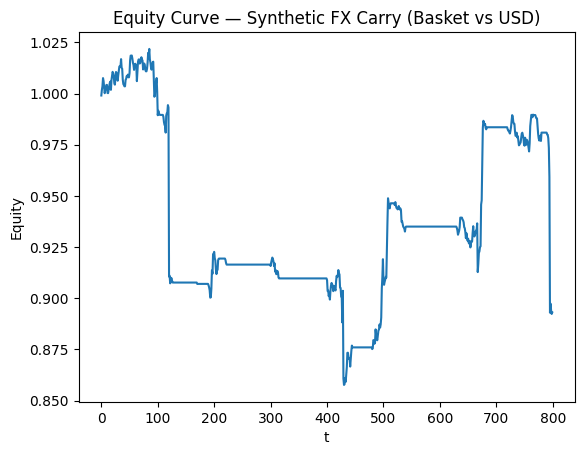

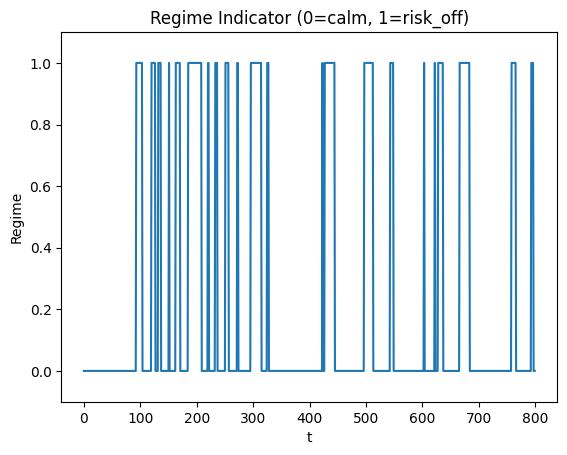

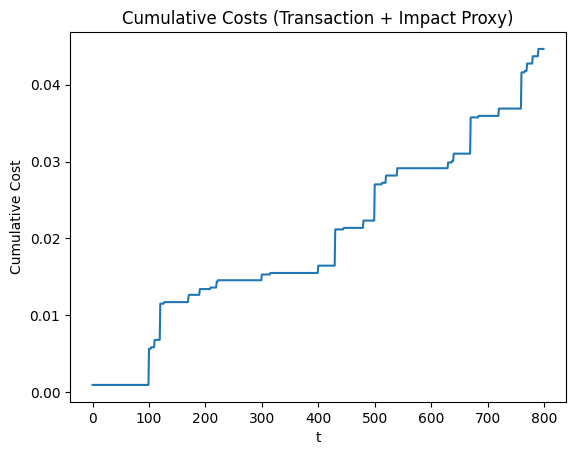

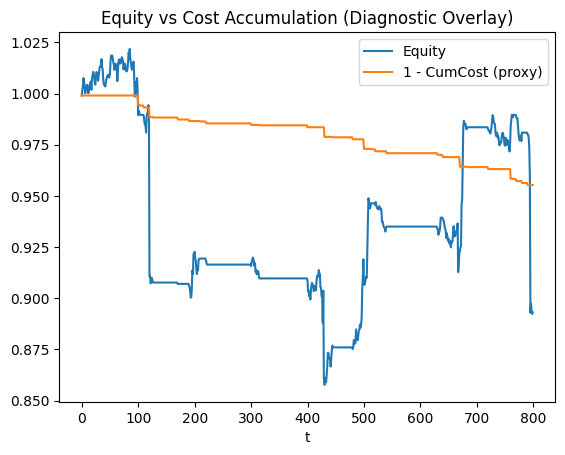

SUMMARY METRICS


,metric,value
0,ann_log_return,-0.035335
1,ann_log_return_calm,-0.045157
2,ann_log_return_risk_off,-0.167478
3,ann_vol,0.082094
4,final_equity,0.893038
5,max_drawdown,0.160682
6,sharpe_like,-0.430428
7,steps,800.000000
8,total_cost,0.044659
9,turnover_abs,22.500000



ACTION COUNTS


,action,count
0,FLAT,370
1,LONG_HIGH_YIELD_BASKET,270
2,RISK_OFF_NEUTRAL,160



POLICY SOURCE COUNTS (LLM vs BASELINE)


,policy_source,count
0,BASELINE,800



ACTION MIX BY REGIME (row-normalized)


action,FLAT,LONG_HIGH_YIELD_BASKET,RISK_OFF_NEUTRAL
regime,,,
calm,0.515974,0.392971,0.091054
risk_off,0.270115,0.137931,0.591954



INTERPRETIVE MECHANISM TABLE


,Mechanism,Surface / State proxy,What you should observe,Fragility mode,Execution implication
0,Forward carry from interest differentials,Mean 30d carry extracted from carry matrix,"Small positive drift in calm, visible as slow ...",Carry is earned locally but is structurally ex...,"If turnover is high, bps-level costs can erase..."
1,Risk-off: USD safe-haven + funding squeeze,Regime=1 with spread compression; higher vol; ...,Drawdowns cluster in risk_off windows; action ...,Tail events dominate distribution; path depend...,Impact rises in stress; delaying de-risking in...
2,Regime clustering (Markov persistence + inject...,Contiguous blocks of risk_off rather than iid ...,"Repeated adverse steps, not single outliers; r...",Leverage/position caps create nonlinear constr...,"Survival constraints are structural design, no..."



LLM NOTE: No rows marked as LLM. If you expected LLM usage, check Cell 8 probe output and Cell 9 telemetry summary.


In [19]:
# CELL 10 (CODE) — Diagnostics + summary metrics + interpretive table (REWRITE COMPLETE)
# Requires: bt from Cell 9

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Helpers
# -----------------------------
def _compute_drawdown(eq: np.ndarray) -> np.ndarray:
    peak = np.maximum.accumulate(eq)
    return 1.0 - eq / np.maximum(peak, 1e-12)

def summarize_metrics(df: pd.DataFrame) -> Dict[str, float]:
    eq = df["equity"].values.astype(float)
    if len(eq) < 5:
        return {"steps": float(len(eq))}

    # log returns for stability
    logeq = np.log(np.maximum(eq, 1e-12))
    r = np.diff(logeq, prepend=logeq[0])

    ann_log_ret = float(np.mean(r) * 252.0)
    ann_vol = float(np.std(r) * np.sqrt(252.0))
    sharpe_like = float(ann_log_ret / (ann_vol + 1e-12))

    dd = _compute_drawdown(eq)
    max_dd = float(np.max(dd))

    turnover = float(np.sum(np.abs(df["trade_size"].values.astype(float))))
    total_cost = float(df["cost"].sum())

    # Regime-specific stats (if present)
    has_reg = "regime" in df.columns
    calm_mask = (df["regime"] == "calm") if has_reg else np.array([False] * len(df))
    risk_mask = (df["regime"] == "risk_off") if has_reg else np.array([False] * len(df))

    def _sub_ann_logret(mask):
        if mask.sum() < 3:
            return np.nan
        eqm = eq[mask.values] if isinstance(mask, pd.Series) else eq[mask]
        logm = np.log(np.maximum(eqm, 1e-12))
        rm = np.diff(logm, prepend=logm[0])
        return float(np.mean(rm) * 252.0)

    return {
        "steps": float(len(df)),
        "final_equity": float(eq[-1]),
        "ann_log_return": ann_log_ret,
        "ann_vol": ann_vol,
        "sharpe_like": sharpe_like,
        "max_drawdown": max_dd,
        "total_cost": total_cost,
        "turnover_abs": turnover,
        "ann_log_return_calm": float(_sub_ann_logret(calm_mask)) if has_reg else np.nan,
        "ann_log_return_risk_off": float(_sub_ann_logret(risk_mask)) if has_reg else np.nan,
    }

# -----------------------------
# Preconditions
# -----------------------------
if "bt" not in globals() or bt is None or len(bt) == 0:
    raise ValueError("Cell 10 requires bt from Cell 9. bt is missing or empty.")

df = bt.copy()

# Make sure required columns exist (defensive)
for col in ["t", "equity", "cost", "trade_size", "action", "policy_source", "regime"]:
    if col not in df.columns:
        df[col] = np.nan

# -----------------------------
# Metrics
# -----------------------------
metrics = summarize_metrics(df)
metrics_table = pd.DataFrame({"metric": list(metrics.keys()), "value": list(metrics.values())})

# Action counts
action_counts = df["action"].value_counts(dropna=False).rename_axis("action").reset_index(name="count")
policy_counts = df["policy_source"].value_counts(dropna=False).rename_axis("policy_source").reset_index(name="count")

# Action-by-regime mix (if regime exists)
if df["regime"].notna().any():
    action_by_regime = pd.crosstab(df["regime"], df["action"], normalize="index")
else:
    action_by_regime = None

# -----------------------------
# Plots (required outputs)
# -----------------------------
# Equity curve
plt.figure()
plt.plot(df["t"], df["equity"])
plt.title("Equity Curve — Synthetic FX Carry (Basket vs USD)")
plt.xlabel("t")
plt.ylabel("Equity")
plt.show()

# Regime plot (0/1)
plt.figure()
reg_idx = (df["regime"] == "risk_off").astype(int) if df["regime"].notna().any() else np.zeros(len(df))
plt.plot(df["t"], reg_idx)
plt.title("Regime Indicator (0=calm, 1=risk_off)")
plt.xlabel("t")
plt.ylabel("Regime")
plt.ylim(-0.1, 1.1)
plt.show()

# Cumulative costs
plt.figure()
plt.plot(df["t"], df["cost"].cumsum())
plt.title("Cumulative Costs (Transaction + Impact Proxy)")
plt.xlabel("t")
plt.ylabel("Cumulative Cost")
plt.show()

# Optional: cost vs equity (helps diagnose if execution dominates)
plt.figure()
plt.plot(df["t"], df["equity"], label="Equity")
plt.plot(df["t"], 1.0 - df["cost"].cumsum(), label="1 - CumCost (proxy)")
plt.title("Equity vs Cost Accumulation (Diagnostic Overlay)")
plt.xlabel("t")
plt.legend()
plt.show()

# -----------------------------
# Interpretive mechanism table (required)
# -----------------------------
interpretive = pd.DataFrame([
    {
        "Mechanism": "Forward carry from interest differentials",
        "Surface / State proxy": "Mean 30d carry extracted from carry matrix",
        "What you should observe": "Small positive drift in calm, visible as slow equity grind when exposure is long",
        "Fragility mode": "Carry is earned locally but is structurally exposed to clustered downside in stress",
        "Execution implication": "If turnover is high, bps-level costs can erase carry; low-trade discipline matters"
    },
    {
        "Mechanism": "Risk-off: USD safe-haven + funding squeeze",
        "Surface / State proxy": "Regime=1 with spread compression; higher vol; jump risk present",
        "What you should observe": "Drawdowns cluster in risk_off windows; action should shift toward neutral/short",
        "Fragility mode": "Tail events dominate distribution; path dependence + stops matter",
        "Execution implication": "Impact rises in stress; delaying de-risking increases both losses and costs"
    },
    {
        "Mechanism": "Regime clustering (Markov persistence + injected stress windows)",
        "Surface / State proxy": "Contiguous blocks of risk_off rather than iid shocks",
        "What you should observe": "Repeated adverse steps, not single outliers; recovery can be slow",
        "Fragility mode": "Leverage/position caps create nonlinear constraints on recovery",
        "Execution implication": "Survival constraints are structural design, not cosmetic backtest choices"
    }
])

# -----------------------------
# Display tables
# -----------------------------
print("SUMMARY METRICS")
display(metrics_table.sort_values("metric").reset_index(drop=True))

print("\nACTION COUNTS")
display(action_counts)

print("\nPOLICY SOURCE COUNTS (LLM vs BASELINE)")
display(policy_counts)

if action_by_regime is not None:
    print("\nACTION MIX BY REGIME (row-normalized)")
    display(action_by_regime)

print("\nINTERPRETIVE MECHANISM TABLE")
display(interpretive)

# -----------------------------
# Optional: quick “LLM worked?” proof
# -----------------------------
if (df["policy_source"] == "LLM").any():
    print("\nLLM SAMPLE DECISIONS (first 10)")
    display(df.loc[df["policy_source"] == "LLM", ["t", "regime", "action", "llm_latency_s", "rationale"]].head(10))
else:
    print("\nLLM NOTE: No rows marked as LLM. If you expected LLM usage, check Cell 8 probe output and Cell 9 telemetry summary.")


##11.CONCLUSION

**Conclusion**

This notebook was built to make a single claim operational: FX carry is compensation for bearing a specific kind of fragility, and the fragility is not an afterthought. When you generate a carry surface from the economic primitives of short rates and tenors, and then force an agent to trade that surface under realistic constraints, the qualitative features of carry become visible in a way that purely statistical approaches often obscure. The value of the exercise is not in any particular number on a performance table. The value is in the structural insight: the “premium” is conditional, and the conditions that make it attractive are precisely the conditions that tend to evaporate when you most need them.

The mechanism-first construction revealed several intertwined lessons. First, the surface matters because it is the market’s organizing object. In this notebook, the surface is a currency-by-tenor carry matrix derived from rate differentials. Even in a synthetic environment, this surface is not arbitrary. It has shape: it scales with tenor, it reflects cross-currency heterogeneity, and it compresses in stress when funding conditions tighten. Treating the surface explicitly changes how you reason about carry. You are no longer thinking in terms of isolated signals; you are thinking in terms of a structured object that evolves with state variables and regimes. That shift is the core abstraction step of the series.

Second, regimes matter because the mapping from surface to PnL is not stable. In calm states, the surface can look like a smooth slope that rewards exposure. In risk-off states, the same surface is typically accompanied by volatility spikes, safe-haven behavior, and a higher probability of abrupt repricing. The notebook’s two-regime simulator makes this dependence explicit, and the diagnostics encourage you to interpret outcomes conditionally. If you see equity erosion clustering in stress windows, that is not a “bug.” That is the mechanism expressing itself. The fragility mode is not random noise; it is the economic price of harvesting carry.

Third, the agentic architecture clarified what it means to “trade the mechanism” rather than “trade the backtest.” A constrained action space forces decisions to be legible. Choosing long carry is choosing to accept latent tail exposure. Choosing short carry is choosing to pay carry in order to hedge a funding-stress state. Choosing neutral is choosing survivability over harvesting. These choices create a language for interpretation: you can inspect action counts and action-by-regime mixes to see whether the agent responds to state changes or behaves as if the world is stationary. In mechanism laboratories, interpretability is not decoration. It is the core deliverable.

Fourth, execution dominated theory in precisely the way professional intuition predicts. Costs and impact were not small perturbations. They were state dependent and turnover dependent, meaning that the same policy can produce very different realized outcomes depending on how often it trades and in which regimes it trades. This is the point of including a cost accumulation curve and reporting turnover. A carry premium is often small on a per-step basis; it cannot survive careless execution. Conversely, stress episodes often combine negative spot moves with higher impact, meaning that late de-risking can produce a double penalty: losses from the market move and costs from crowded execution. The notebook’s environment makes that coupling visible and auditable.

The fragility modes you should now recognize are structural signatures rather than backtest artifacts. One signature is clustered drawdowns that coincide with risk-off regimes. Another signature is an apparent “good period” of small gains that is subsequently erased by a short sequence of large adverse moves. A third signature is cost-driven decay, where equity drifts downward not because the mechanism fails, but because turnover and impact overwhelm a small premium. These are different failure modes with different implications. Mechanism-first practice means diagnosing which mode you are seeing, then modifying the laboratory in a disciplined way to test hypotheses about the cause.

The correct iteration agenda is therefore experimental and falsifiable. If you suspect that carry is “too easy,” increase jump intensity or risk-off persistence and watch whether the equity curve becomes more realistically fragile.